# Features y Target

Los features y el target saldran del preprocesamiento en FEATURE ENGINEERING

In [1]:
# Importamos libreriras necesarias para armar target y features 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importamos el DataFrame: Es el ultimo de mi notebook anterior. Tiene las X 'no texto' y 'texto y el target a predecir (y)
# Las features 'no texto' estan listas para usar, las de texto faltan vectorizarlas

df = pd.read_csv('df_export.csv')

In [3]:
# Preparamos el target
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(df['genero_1'])

In [4]:
# Preparamos las features (por el momento las 'no texto)

X = df.drop(columns=['Unnamed: 0', 'coleccion', 'contratapa','genero_1','sinopsis', 'titulo', 'texto','normal'])

# Funciones de evaluacion de los modelos

Vamos a crear un set de funciones de evaluacion (con base en train_test_split)

In [5]:
# Importamos los modulos necesarios para armar ambas funciones
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

La logica de evaluacion sera la siguiente:
- Evaluar el modelo de base sin tunear hiperparamentros en set de entrenamiento y test (evaluation_model)
- Evaluar el modelo de base con tuneo de hiperparametros en GridSearchCV (gs_evaluation_model)
- Evaluar el modelo de base sin tuneear hiperparamentros con BaggingClassifier (bagging_evaluation)
- Evaluar el modelo de base con tuneo de hiperparametros del modelo base y del Bagging (gs_bagging_evaluation)

In [6]:
# Generamos el set de entrenamiento y testeo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Evaluacion en train_test_split: para usar la funcion hay que pasarle como argumento el modelo a evaluar (instanciarlo primero)

def evaluation_model(base_model):
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=['Pred_'+c for c in df['genero_1'].unique()], index= df['genero_1'].unique())
    classification = classification_report(y_test,y_pred)
    
    print('Accuracy:%s \n' % accuracy)
    
    print('Classification Report: \n %s' % classification)
    
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('Etiqueta verdadera')
    plt.ylabel('Etiqueta predicha');
    
    # Return para poder almacenar el resultado en un DataFrame
    return accuracy

In [8]:
# Evaluacion del modelo base con GridSearch: para usar la funcion hay que definir por fuera los posibles parametros a tunear (en funcion de cada modelo)

def gs_model_evaluation(base_model,params):
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    gs = GridSearchCV(base_model,params,cv=kf,n_jobs=-1,verbose=1)
    gs.fit(X_train,y_train)
    
    print('Los mejores parametros son: \n %s \n' % gs.best_params_)
    
    print('El accuracy alcanzado es: \n %s \n' % gs.best_score_)
    
    return gs.best_score_


In [9]:
# Evaluacion del modelo base con Bagging 

from sklearn.ensemble import BaggingClassifier 

def bagging_evaluation(base_model):
    model_bagging = BaggingClassifier(base_model)
    model_bagging.fit(X_train, y_train)
    y_pred = model_bagging.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=['Pred_'+c for c in df['genero_1'].unique()], index= df['genero_1'].unique())
    classification = classification_report(y_test,y_pred)
    
    print('Accuracy:%s \n' % accuracy)
    
    print('Classification Report: \n %s' % classification)
    
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('Etiqueta verdadera')
    plt.ylabel('Etiqueta predicha');
    
    return accuracy
    

In [10]:
# Evaluacion del modelo de bagging con Grid Search

def gs_bagging_evaluation(base_model, params_base):
    
    # Hace un GridSearch con los parametros del modelo base
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    gs = GridSearchCV(base_model,params_base,cv=kf,n_jobs=-1,verbose=1)
    gs.fit(X_train,y_train)
    
    # Los hiperparametros del Bagging son unicos (no import el modelo), por eso paso un solo diccionario
    bagging_params = {'n_estimators':[10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features':[0.7, 1.0],
                  'bootstrap_features': [True, False]}
    
    bag_gs = GridSearchCV(BaggingClassifier(gs.best_estimator_), bagging_params, cv=kf, n_jobs=-1, verbose=1)
    bag_gs.fit(X_train,y_train)
    
    print('Los mejores parametros son: \n %s \n' % bag_gs.best_params_)
    
    print('El accuracy alcanzado es: \n %s \n' % bag_gs.best_score_)
    
    return bag_gs.best_score_
    

In [11]:
# Creamos un diccionario donde ir almacenando los scores de los modelos evaluados. Las funciones se ejecutan adentro del diccionario para ahorrar pasos
resultados = {}

## Decision Tree Classifier 

In [12]:
# Importamos CARS y Bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [13]:
# Instanciamos el modelo
DT = DecisionTreeClassifier()

Accuracy:0.574030087094 

Classification Report: 
              precision    recall  f1-score   support

          0       0.53      0.63      0.57        79
          1       0.16      0.18      0.17        57
          2       0.20      0.20      0.20        25
          3       0.65      0.63      0.64       232
          4       0.22      0.17      0.19        36
          5       0.90      0.91      0.90       205
          6       0.50      0.50      0.50        44
          7       0.45      0.53      0.49       113
          8       0.31      0.29      0.30        49
          9       0.46      0.48      0.47        96
         10       0.71      0.60      0.65       227
         11       0.40      0.43      0.41       100

avg / total       0.58      0.57      0.58      1263



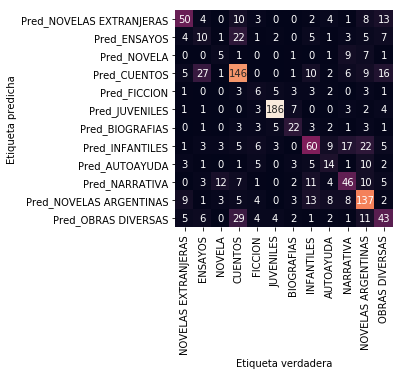

In [14]:
# Ejecutamos la funcion y almacenamos el resultado en un diccionario
resultados['dt'] = {'model': DT,
                    'score': evaluation_model(DT)}

In [15]:
# Definimos los parametros del arbol de base para tunear en GridSearchCV

parametros_dt = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [None, 5, 10],'min_samples_split': [2, 5],'min_samples_leaf': [1, 2, 3]}


resultados['dt_gs'] = {'model': DT,
                       'score': gs_model_evaluation(DT, parametros_dt)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   15.6s finished


Los mejores parametros son: 
 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'} 

El accuracy alcanzado es: 
 0.592555929519 



Accuracy:0.616785431512 

Classification Report: 
              precision    recall  f1-score   support

          0       0.54      0.71      0.62        79
          1       0.20      0.16      0.18        57
          2       0.38      0.36      0.37        25
          3       0.67      0.75      0.71       232
          4       0.14      0.11      0.12        36
          5       0.93      0.92      0.92       205
          6       0.65      0.55      0.59        44
          7       0.49      0.56      0.52       113
          8       0.31      0.22      0.26        49
          9       0.54      0.50      0.52        96
         10       0.68      0.68      0.68       227
         11       0.45      0.39      0.42       100

avg / total       0.61      0.62      0.61      1263



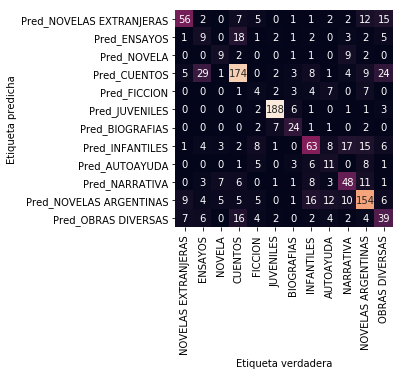

In [16]:
# Evaluamos DecisionTreeClassifier con Bagging

resultados['dt_bg'] = {'model': DT,
                       'score': bagging_evaluation(DT)}

In [17]:
# Evaluamos DecisionTreeClassifier Bagging con GridSearch

resultados['dt_bg_gs'] = {'model': DT,
                         'score': gs_bagging_evaluation(DT, parametros_dt)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.2s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   46.5s finished


Los mejores parametros son: 
 {'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 20} 

El accuracy alcanzado es: 
 0.653137992477 



# Random Forest y Extra Trees

In [18]:
# Import los modelos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [19]:
# Instancio los modelos
RF = RandomForestClassifier()
ET = ExtraTreesClassifier()

Accuracy:0.637371338084 

Classification Report: 
              precision    recall  f1-score   support

          0       0.60      0.75      0.66        79
          1       0.24      0.16      0.19        57
          2       0.35      0.24      0.29        25
          3       0.63      0.76      0.69       232
          4       0.17      0.11      0.14        36
          5       0.92      0.94      0.93       205
          6       0.67      0.59      0.63        44
          7       0.49      0.55      0.52       113
          8       0.43      0.33      0.37        49
          9       0.57      0.56      0.57        96
         10       0.70      0.70      0.70       227
         11       0.57      0.42      0.48       100

avg / total       0.62      0.64      0.63      1263



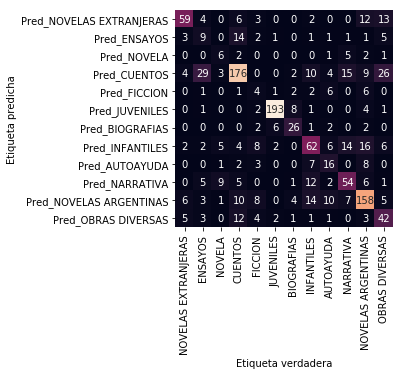

In [20]:
# Evaluo RandomForest

resultados['rf'] = {'model': RF,
                    'score': evaluation_model(RF)}

In [23]:
# Evaluo RandomForest con GS

parametros_rf = {'n_estimators':[3, 5, 10, 50],'criterion': ['gini', 'entropy'],'max_depth': [None, 3, 5],'min_samples_split': [2,5],'class_weight':[None, 'balanced']}


resultados['rf_gs'] = {'model': RF,
                       'score': gs_model_evaluation(RF, parametros_rf)}

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.2min finished


Los mejores parametros son: 
 {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50} 

El accuracy alcanzado es: 
 0.655315779054 



Accuracy:0.631037212985 

Classification Report: 
              precision    recall  f1-score   support

          0       0.55      0.68      0.61        79
          1       0.31      0.19      0.24        57
          2       0.30      0.32      0.31        25
          3       0.64      0.76      0.69       232
          4       0.17      0.11      0.14        36
          5       0.95      0.93      0.94       205
          6       0.68      0.57      0.62        44
          7       0.50      0.52      0.51       113
          8       0.35      0.29      0.31        49
          9       0.55      0.54      0.55        96
         10       0.68      0.70      0.69       227
         11       0.58      0.45      0.51       100

avg / total       0.62      0.63      0.62      1263



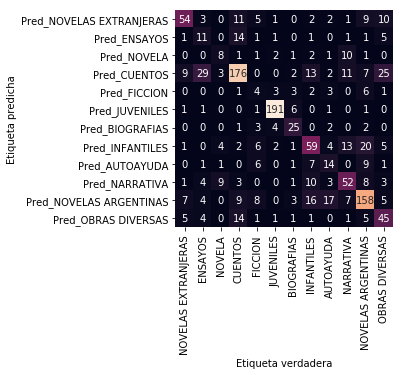

In [24]:
# Evaluo ExtraTrees

resultados['et'] = {'model': ET,
                    'score': evaluation_model(ET)}

In [25]:
# Evaluo ExtraTrees con GS

parametros_et = {'n_estimators':[3, 5, 10, 50],'criterion': ['gini', 'entropy'],'max_depth': [None, 3, 5],'min_samples_split': [2,5],'class_weight':[None, 'balanced']}


resultados['et_gs'] = {'model': ET,
                       'score': gs_model_evaluation(ET, parametros_et)}

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.1min finished


Los mejores parametros son: 
 {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50} 

El accuracy alcanzado es: 
 0.660859235795 



# GradientBoost

In [26]:
# Importo el modelo
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
# Instancio el modelo

GB = GradientBoostingClassifier()

Accuracy:0.658749010293 

Classification Report: 
              precision    recall  f1-score   support

          0       0.62      0.75      0.68        79
          1       0.40      0.07      0.12        57
          2       0.50      0.28      0.36        25
          3       0.65      0.86      0.74       232
          4       0.25      0.06      0.09        36
          5       0.95      0.93      0.94       205
          6       0.77      0.61      0.68        44
          7       0.54      0.52      0.53       113
          8       0.45      0.29      0.35        49
          9       0.64      0.53      0.58        96
         10       0.56      0.79      0.66       227
         11       0.76      0.39      0.52       100

avg / total       0.65      0.66      0.63      1263



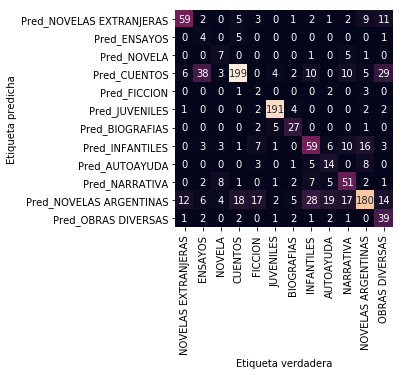

In [28]:
# Evaluo el GradientBoosting

resultados['gb'] = {'model': GB,
                    'score': evaluation_model(GB)}

In [29]:
# Evaluo GradientBoost con GS

parametros_gb = {'learning_rate':[0.1,0.2,0.3], 'n_estimators':[50,100]}


resultados['gb_gs'] = {'model': GB,
                       'score': gs_model_evaluation(GB, parametros_gb)}

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min finished


Los mejores parametros son: 
 {'learning_rate': 0.2, 'n_estimators': 100} 

El accuracy alcanzado es: 
 0.66600673134 



# Regresion Logistica

In [30]:
#Importo el modelo
from sklearn.linear_model import LogisticRegression

In [31]:
#Instancio la regresion
LR = LogisticRegression()

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy:0.645288994458 

Classification Report: 
              precision    recall  f1-score   support

          0       0.60      0.67      0.63        79
          1       0.00      0.00      0.00        57
          2       0.50      0.16      0.24        25
          3       0.62      0.88      0.73       232
          4       1.00      0.08      0.15        36
          5       0.89      0.91      0.90       205
          6       0.69      0.55      0.61        44
          7       0.55      0.52      0.54       113
          8       0.55      0.22      0.32        49
          9       0.55      0.55      0.55        96
         10       0.59      0.85      0.70       227
         11       0.60      0.24      0.34       100

avg / total       0.62      0.65      0.60      1263



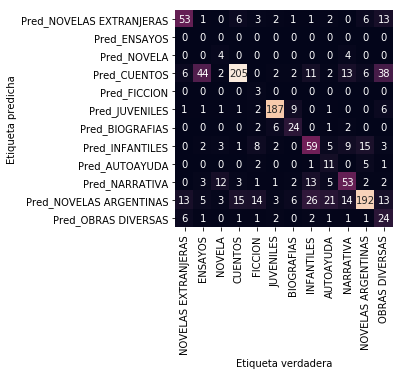

In [32]:
#Evaluo la regresion logistica
resultados['lr'] = {'model': LR,
                    'score': evaluation_model(LR)}

In [33]:
# Evaluo Logistic regression Bagging con GS

parametros_lr = {'penalty':['l1','l2']}

resultados['lr_bg_gs'] = {'model': LR,
                          'score': gs_bagging_evaluation(LR, parametros_lr)}

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.6s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.4min finished


Los mejores parametros son: 
 {'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10} 

El accuracy alcanzado es: 
 0.659671352207 



# Support Vector Machine

In [34]:
# Importo el modelo
from sklearn.svm import SVC

In [35]:
# Instancio SVM
SVM = SVC()

Accuracy:0.423594615994 

Classification Report: 
              precision    recall  f1-score   support

          0       0.38      0.04      0.07        79
          1       0.00      0.00      0.00        57
          2       0.00      0.00      0.00        25
          3       0.34      0.60      0.44       232
          4       0.00      0.00      0.00        36
          5       0.89      0.84      0.86       205
          6       0.57      0.09      0.16        44
          7       0.22      0.14      0.17       113
          8       0.25      0.02      0.04        49
          9       0.45      0.27      0.34        96
         10       0.34      0.66      0.44       227
         11       0.38      0.24      0.29       100

avg / total       0.40      0.42      0.38      1263



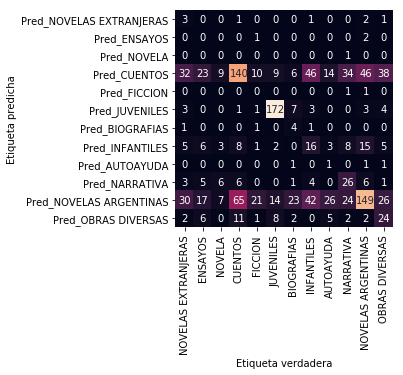

In [36]:
# Evaluo SVM
resultados['svm'] = {'model': SVM,
                     'score': evaluation_model(SVM)}

PARA FINALIZAR EVALUAMOS LA PERFORMANCE DE TODOS LOS MODELOS CONSIDERADOS

In [37]:
# Usamos el diccionario y lo transponemos
performance = pd.DataFrame(resultados).T

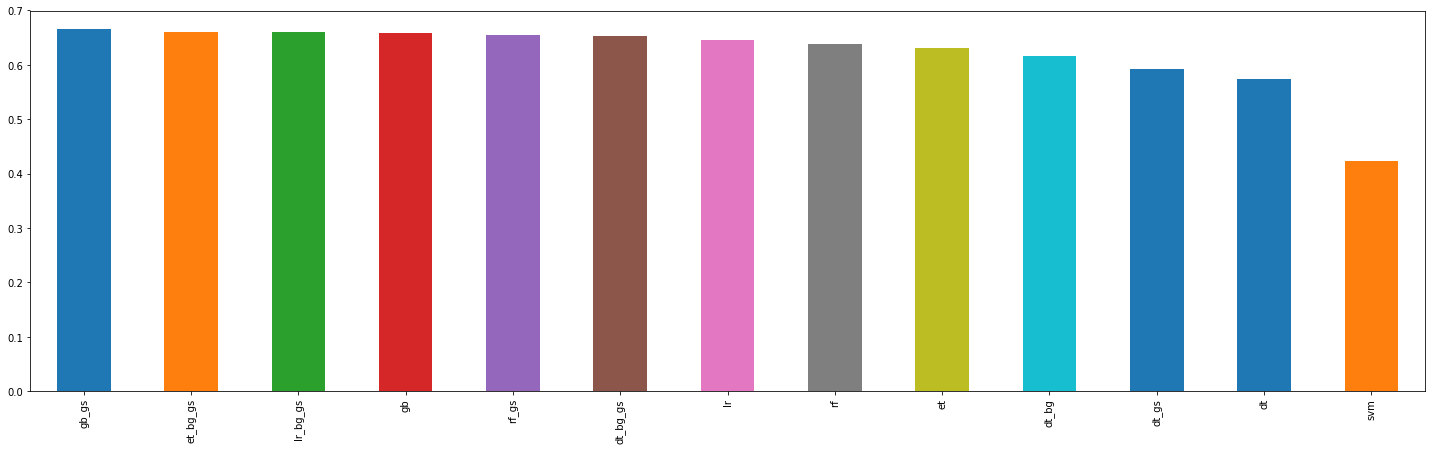

In [38]:
plt.figure(figsize=(25,7))
performance['score'].sort_values(ascending=False).plot(kind='bar')

# LightGBM

In [39]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

In [40]:
# Vamos a probar con SMOTE para ver si las clases que no predice bien(las minoritarias) pueden ser captadas mejor con un oversampling
pipe = make_pipeline(SMOTE(), LGBMClassifier())

In [41]:
# Seteo los parametros del modelo
params = {'smote':[None,SMOTE()],
          'lgbmclassifier__n_estimators':[20,40,80],
          'lgbmclassifier__max_depth':[5,8,12]
         }

In [42]:
# Instancio el lightGBM con Smote dentro de un GS. No pongo como scoring 'auc_score' porque el auc no soporta predicciones multiclase
gs_lgbm = GridSearchCV(pipe,params)

In [43]:
gs_lgbm.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('lgbmclassifier', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_dept...0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'smote': [None, SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)], 'lgbmclassifier__n_estimators': [20, 40, 80], 'lgbmclassifier__max_depth': [5, 8, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
gs_lgbm.best_score_

0.62601465056424466

# CURVA ROC PARA LOS MEJORES MODELOS

EXTRATREES

In [45]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

In [46]:
parametros_et = {'n_estimators':[3, 5, 10, 50],'criterion': ['gini', 'entropy'],'max_depth': [None, 3, 5],'min_samples_split': [2,5],'class_weight':[None, 'balanced']}

kf = KFold(n_splits=4,shuffle=True,random_state=42)
gs_et = GridSearchCV(ET,parametros_et, cv=kf, n_jobs=-1, verbose=True)

gs_et.fit(X_train,y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   33.1s finished


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [3, 5, 10, 50], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, 5], 'min_samples_split': [2, 5], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [47]:
gs_et.best_score_

0.66224509998020198

In [48]:
# El AUC no funciona con problemas multiclase
y_pred_et_auc = gs_et.best_estimator_.predict_proba(X_test)

In [49]:
# No soporta multiclase
#roc_auc_score(y_pred, y_pred_et_auc)

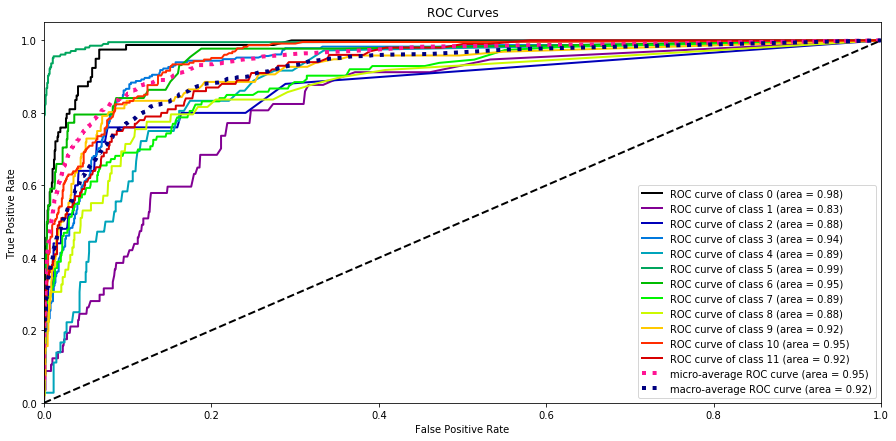

In [50]:
plot_roc(y_test,y_pred_et_auc, figsize=(15,7))